<a href="https://colab.research.google.com/github/kmsaleh/Inheritance-in-ML-projects/blob/main/ML_inhritance_Extended_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Define a BaseModel**<br>
Let’s code a base machine learning model class that is defined by some standard variable. This class then will have a method to load the data, one to train, another to evaluate, and one to preprocess the data. However, each specific model will preprocess the data differently, so the subclasses that will inherit the base model shall rewrite the preprocessing method.
Be alert, the BaseMLModel itself inherit the ABC class. This is a way to tell Python that this class is an abstract class, and shall not be used, but it's only a template to build subclasses.

The same is true for the preprocess_train_data which is marked a @abstactmethod. This means that subclasses must reimplement this method.

In [ ]:
from abc import ABC, abstractmethod
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # extension no. 1  khaled
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class BaseMLModel(ABC):
    def __init__(self, test_size = 0.2, random_state = 42):
        self.model = None   # this will be set in subclass
        self.test_size = test_size
        self.random_state = random_state
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X,y,test_size = self.test_size,random_state = self.random_state
        )

    @abstractmethod
    def preprocess_train_data(self):
        # each method can define custom preprocessing for training data
        pass

    def train(self):
        self.X_train, self.y_train = self.preprocess_train_data()
        self.model.fit(self.X_train, self.y_train)

    def evaluate(self):
        self.X_test = self.preprocess_test_data()   #preprocess test data
        predictions = self.model.predict(self.X_test)
        return accuracy_score(self.y_test, predictions)

    @abstractmethod
    def plotit(self):
         # each method can define custom plots
         pass


First, we can implement a LogisticRegressionModel. Which will have its own preprocessing algorithm.

In [ ]:
class LogisticRegressionModel(BaseMLModel):
    def __init__(self, **kwargs):
        super().__init__()
        self.model = LogisticRegression(**kwargs)
        self.mean = None
        self.std = None

    def preprocess_train_data(self):
        # standardize features for Logistic Regression
        self.mean = self.X_train.mean(axis = 0)
        self.std = self.X_train.std(axis = 0)
        X_train_scaled = (self.X_train - self.mean)/self.std
        return X_train_scaled, self.y_train

    def preprocess_test_data(self):
        # Apply the same standardization to test data
        if self.mean is None or self.std is None:
            raise ValueError("Training data must be preprocessed before preprocessing test data.")
        X_test_scaled = (self.X_test - self.mean)/self.std
        return X_test_scaled

    def evaluate(self):
        self.X_test = self.preprocess_test_data()   #preprocess test data
        predictions = self.model.predict(self.X_test)
        return accuracy_score(self.y_test, predictions)

    def plotit(self):
        pass




Then we can define as many subclasses as we want. I define here one for a Random Forest.

In [ ]:
class RandomForestModel(BaseMLModel):
    def __init__(self, n_important_features=3, **kwargs):
        super().__init__()
        self.model = RandomForestClassifier(**kwargs)
        self.n_important_features = n_important_features
        self.selected_feayures_indices = None

    def preprocess_train_data(self):
        # select top 'n_important_features' features based on variance
        feature_variances = np.var(self.X_train, axis=0)
        self.selected_features_indices = np.argsort(feature_variances)[-self.n_important_features:]
        X_train_selected = self.X_train[:, self.selected_features_indices]
        return X_train_selected, self.y_train

    def preprocess_test_data(self):
        # Apply the same feature selection to the test data
        if self.selected_features_indices is None:
            raise ValueError("Training data must be preprocessed before preprocessing test data.")
        X_test_selected = self.X_test[:, self.selected_features_indices]
        return X_test_selected

    def evaluate(self):
        self.X_test = self.preprocess_test_data()   #preprocess test data
        predictions = self.model.predict(self.X_test)
        return accuracy_score(self.y_test, predictions)

    def plotit(self):
        pass


**Extension to the code**<br> 1- <i>LinearDiscriminantAnalysis (LDA)


In [ ]:
class LDAModel(BaseMLModel):
    def __init__(self, **kwargs):
        super().__init__()
        self.model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(**kwargs)
        self.lda_extractor = None  # To reuse the same LDA object for training and testing

    def preprocess_train_data(self):
        n_classes = len(set(self.y_train))
        self.lda_extractor = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(
            n_components=min(n_classes - 1, self.X_train.shape[1])
        )
        self.X_train = self.lda_extractor.fit_transform(self.X_train, self.y_train)
        return self.X_train, self.y_train

    def preprocess_test_data(self):
        if self.lda_extractor is None:
            raise ValueError("LDA extractor must be fitted before transforming test data.")
        self.X_test = self.lda_extractor.transform(self.X_test)
        return self.X_test

    def transform(self, X):
        if self.lda_extractor is None:
            raise ValueError("LDA extractor must be fitted before transforming data.")
        return self.lda_extractor.transform(X)

    def train(self):
        self.X_train, self.y_train = self.preprocess_train_data()
        self.model.fit(self.X_train, self.y_train)

    def evaluate(self):
        self.X_test = self.preprocess_test_data()
        predictions = self.model.predict(self.X_test)

        print("Confusion Matrix:")
        print(confusion_matrix(self.y_test, predictions))

        print("Classification Report:")
        print(classification_report(self.y_test, predictions, target_names=data.target_names))

        return accuracy_score(self.y_test, predictions)


    def plotit(self):
        # Transform data to 2D using LDA
        X_lda = lda_model.transform(X)

        # Plot the transformed data
        plt.figure(figsize=(8, 6))
        for class_value in range(len(data.target_names)):
            plt.scatter(X_lda[y == class_value, 0], X_lda[y == class_value, 1], label=data.target_names[class_value])
        plt.xlabel('LD1')
        plt.ylabel('LD2')
        plt.legend()
        plt.title('LDA Projection')
        plt.show()


Then we can use all of this in our main function:

Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 1.0
Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

LDA Model Accuracy: 1.0


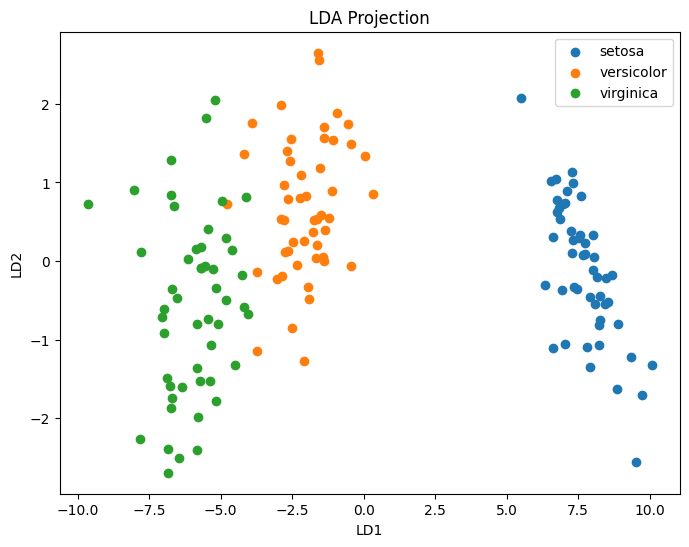

In [ ]:
if __name__ == "__main__":
    # Load the dataset
    data = load_iris()
    X,y = data.data , data.target

    # Logistic Regression
    log_reg_model = LogisticRegressionModel(max_iter = 200)
    log_reg_model.load_data(X,y)
    log_reg_model.train()
    print(f"Logistic Regression Accuracy: {log_reg_model.evaluate()}")
    print('=========================================================')

    # Random Forest
    rf_model = RandomForestModel(n_estimators = 100, n_important_features = 3)
    rf_model.load_data(X,y)
    rf_model.train()
    print(f"Random Forest Accuracy: {rf_model.evaluate()}")
    print('=========================================================')

    # LDA Model
    lda_model = LDAModel()
    lda_model.load_data(X, y)
    lda_model.train()
    accuracy = lda_model.evaluate()
    print(f"LDA Model Accuracy: {accuracy}")
    lda_model.plotit()
    print('=========================================================')


